In [1]:
from PIL import Image  # To transform the image in the Processor
import numpy as np
import gym

# Convolutional Backbone Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute

# Keras-RL
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [2]:
env = gym.make("snake:yeks_snake-v0")
nb_actions = env.action_space.n

pygame 2.1.2 (SDL 2.0.18, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
nb_actions

4

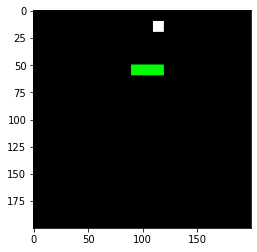

In [4]:
import matplotlib.pyplot as plt

env.reset()
env.render('human')
action = env.action_space.sample()
img,reward,done,info = env.step(action)
plt.figure()
plt.imshow(img)

In [5]:
IMG_SHAPE = (84, 84)
WINDOW_LENGTH = 4

In [6]:
class ImageProcessor(Processor):
    def process_observation(self, observation):
        # First convert the numpy array to a PIL Image
        img = Image.fromarray(observation)
        # Then resize the image
        img = img.resize(IMG_SHAPE)
        # And convert it to grayscale  (The L stands for luminance)
        img = img.convert("L")
        # Convert the image back to a numpy array and finally return the image
        img = np.array(img)
        return img.astype('uint8')  # saves storage in experience memory
    
    def process_state_batch(self, batch):

        # We divide the observations by 255 to compress it into the intervall [0, 1].
        # This supports the training of the network
        # We perform this operation here to save memory.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [7]:
input_shape = (WINDOW_LENGTH, IMG_SHAPE[0], IMG_SHAPE[1])
input_shape

(4, 84, 84)

In [8]:
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))

model.add(Convolution2D(32, (8, 8), strides=(4, 4),kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 activation (Activation)     (None, 20, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 activation_1 (Activation)   (None, 9, 9, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 activation_2 (Activation)   (None, 7, 7, 64)          0

In [9]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

In [10]:
processor = ImageProcessor()

In [11]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

In [12]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
              train_interval=4, delta_clip=1)

In [13]:
dqn.compile(tf.keras.optimizers.Adam(learning_rate=.00025), metrics=['mae'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
weights_filename = 'test_dqn_snake_weights.h5f'
checkpoint_weights_filename = 'test_dqn_' + "snake" + '_weights_{step}.h5f'
checkpoint_callback = ModelIntervalCheckpoint(checkpoint_weights_filename, interval=100000)

In [15]:
dqn.fit(env, nb_steps=1500000, callbacks=[checkpoint_callback], log_interval=100000, visualize=False)

# After training is done, we save the final weights one more time.
dqn.save_weights(weights_filename, overwrite=True)

Training for 1500000 steps ...
Interval 1 (0 steps performed)
    16/100000 [..............................] - ETA: 11:47 - reward: -0.3125    

C:\ProgramData\Anaconda3\envs\gym\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


 50004/100000 [==============>...............] - ETA: 6:07 - reward: -0.2476

AttributeError: 'Adam' object has no attribute 'get_updates'

In [ ]:
env.sleep = 0.2

In [ ]:
dqn.test(env, nb_episodes=1, visualize=True)